In [36]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [37]:
!pip install scikit-multilearn==0.2.0

In [38]:
import tensorflow as tf

# Disable GPU (if available)
tf.config.set_visible_devices([], 'GPU')

# Or, you can specify the CPU device explicitly
# tf.config.set_visible_devices([], 'GPU:0')

# Now TensorFlow will use only the CPU

In [39]:
!pip install transformers emoji datetime tqdm

In [40]:
import torch
import torch.nn as nn
import json
import random
from transformers import BertForSequenceClassification,  BertConfig
from transformers import get_linear_schedule_with_warmup
import time
import datetime
import random
import re
import numpy as np
import emoji
from transformers import *
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold
from transformers import BertTokenizer
# from transformers import BertForSequenceClassification, AdamW, BertConfig
from sklearn.metrics import accuracy_score,f1_score
from sklearn.utils.class_weight import compute_class_weight
from transformers import BertTokenizer
# from transformers import BertForSequenceClassification, AdamW, BertConfig
from keras.preprocessing.sequence import pad_sequences
from torch.utils.data import TensorDataset, RandomSampler, SequentialSampler, DataLoader
from sklearn.metrics import *
from sklearn.utils import *
import os

In [41]:
os.chdir('/content/drive/MyDrive/NLP_Project/NLP/testing')
cwd = os.getcwd()  # Get the current working directory (cwd)
files = os.listdir(cwd)  # Get all the files in that directory
print("Files in %r: %s" % (cwd, files))

Files in '/content/drive/.shortcut-targets-by-id/1_CDY8Dm7L5Tja0e9ZZ13F9diyKUaPn_n/NLP_Project/NLP/testing': ['test_en_l1.csv', 'test_en_l2.csv', 'test_en_l3.csv', 'test_hi_l1.csv', 'test_hi_l2.csv', 'test_hi_l3.csv', 'test_ta_l1.csv', 'test_ta_l2.csv', 'test_ta_l3.csv', 'test_en_l1 (1).gsheet', 'test_en_l1.gsheet', 'test_en_l2.gsheet', 'test_hi_l1 (2).gsheet', 'test_hi_l1 (1).gsheet', 'hindi', 'test_hi_l1.gsheet']


In [42]:
def Diff(a,b):
    return list(set(a) -set(b))

def re_sub(pattern, repl,text):
    return re.sub(pattern, repl, text)


def preprocess_sent(sent):
    sent = re.sub(r"http\S+", " ", sent.lower())
    sent = re.sub(r"@\S+", "@user", sent)

    #print(sent)
    sent = re_sub(r"[-+]?[.\d]*[\d]+[:,.\d]*", "",sent)
    sent = emoji.demojize(sent)
    sent = re_sub(r"[:\*]", " ",sent)
    sent = re.sub(r"[<\*>]", " ",sent)
    sent = sent.replace("&amp;", " ")
    sent = sent.replace("ðŸ¤§", " ")
    sent = sent.replace("\n", " ")
    sent = sent.replace("ðŸ˜¡", " ")
    return sent

In [43]:
def create_attention_masks(input_ids):
    attention_masks = []
    for seq in tqdm(input_ids):
        seq_mask = [float(i>0) for i in seq]
        attention_masks.append(seq_mask)
    return np.array(attention_masks)

def getFeaturesandLabel(X,y):
    sentences = list(X)
    sentences = ["[CLS] "+ preprocess_sent(i) + " [SEP]"for i in sentences]
    tokenizer_texts = list(map(lambda t: tokenizer.tokenize(t)[:512], tqdm(sentences)))
    input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tqdm(tokenizer_texts)]
    input_ids = pad_sequences(sequences = input_ids, maxlen = 128, dtype = 'long', padding='post', truncating='post')
    attention_masks_data = create_attention_masks(input_ids)
    X_data = torch.tensor(input_ids)
    attention_masks_data = torch.tensor(attention_masks_data)
    y_data = torch.tensor(y)
    return X_data, attention_masks_data, y_data


In [44]:
import pandas as pd
d1 = pd.read_csv('/content/drive/MyDrive/NLP_Project/NLP/testing/test_ta_l1.csv')

In [45]:
col_lst = ['ta_a1', 'ta_a2', 'ta_a3', 'ta_a4', 'ta_a5', 'ta_a6']
for col in col_lst:
    d1[col] = pd.to_numeric(d1[col], errors='coerce')

d1['label'] = d1[col_lst].max(axis=1, skipna=True).astype(int)
d1 = d1.drop(col_lst, axis=1)
d1['label'] = d1['label'].astype(int)
d1 = d1[['label', 'text']]

In [46]:
tokenizer = BertTokenizer.from_pretrained('google/muril-base-cased', do_lower_case = True)

loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--google--muril-base-cased/snapshots/afd9f36c7923d54e97903922ff1b260d091d202f/vocab.txt
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at /root/.cache/huggingface/hub/models--google--muril-base-cased/snapshots/afd9f36c7923d54e97903922ff1b260d091d202f/special_tokens_map.json
loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--google--muril-base-cased/snapshots/afd9f36c7923d54e97903922ff1b260d091d202f/tokenizer_config.json
loading file tokenizer.json from cache at None
loading file chat_template.jinja from cache at None
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--google--muril-base-cased/snapshots/afd9f36c7923d54e97903922ff1b260d091d202f/config.json
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null

In [47]:
# Convert the relevant columns to numeric before applying max
# for col in ['ta_a1', 'ta_a2', 'ta_a3', 'ta_a4', 'ta_a5', 'ta_a6']:
#     d1[col] = pd.to_numeric(d1[col], errors='coerce')  # errors='coerce' to handle non-numeric values

# d1['label'] = d1[['ta_a1', 'ta_a2', 'ta_a3', 'ta_a4', 'ta_a5', 'ta_a6']].max(axis=1, skipna=True).astype(int)  # skipna=True to ignore empty values

# d1 = d1.drop(['key', 'ta_a1', 'ta_a2', 'ta_a3', 'ta_a4', 'ta_a5', 'ta_a6'], axis=1)
# d1['label'] = d1['label'].astype(int)
# d1 = d1[['label', 'text']]
# d1

In [48]:
X_ts, y_ts = list(d1['text']), list(d1['label'])
# X_ts

In [49]:
X_test, attention_masks_train, y_test = getFeaturesandLabel(X_ts,y_ts)

100%|██████████| 1135/1135 [00:00<00:00, 14562.93it/s]


In [50]:
import torch
from transformers import AutoModelForSequenceClassification
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
import numpy as np

# Load the model
model_name = "Hate-speech-CNERG/indic-abusive-allInOne-MuRIL"
model = AutoModelForSequenceClassification.from_pretrained(model_name)
model.eval()  # Set to evaluation mode

# Move to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
X_test = X_test.to(device)
attention_masks_train = attention_masks_train.to(device)  # Note: Should be renamed to attention_masks_test
y_test = y_test.cpu().numpy()  # Keep labels on CPU for sklearn metrics

# Inference
batch_size = 16  # Manual batching to avoid memory issues
predictions = []

for i in range(0, len(X_test), batch_size):
    input_ids_batch = X_test[i:i+batch_size]
    attention_mask_batch = attention_masks_train[i:i+batch_size]

    with torch.no_grad():
        outputs = model(input_ids=input_ids_batch, attention_mask=attention_mask_batch)
    logits = outputs.logits
    preds = torch.argmax(logits, dim=-1).cpu().numpy()
    predictions.extend(preds)



loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--Hate-speech-CNERG--indic-abusive-allInOne-MuRIL/snapshots/b3bc73f9a41d2ffe44280b6651a60b32ce276f50/config.json
Model config BertConfig {
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "embedding_size": 768,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.50.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 197285
}

loading weights file model.safetensors from cache at /root/.cache/huggingface/hub/models--Hate-speech-CNERG--indic-abusive-allInOne-MuRIL/snapsho

In [52]:
# Compute metrics
print("Classification Report:")
print(classification_report(y_test, predictions, target_names=["Not Hate", "Hate"], digits=2))

# Compute averages
avg_precision = precision_score(y_test, predictions, average="macro")
avg_recall = recall_score(y_test, predictions, average="macro")
avg_f1 = f1_score(y_test, predictions, average="macro")
# auc_score = roc_auc_score(y_test, probabilities[:, 1])  # Probability of Class 1 (Hate)

print(f"\nAverage Metrics:")
print(f"Average Precision: {avg_precision:.2f}")
print(f"Average Recall: {avg_recall:.2f}")
print(f"Average F1-Score: {avg_f1:.2f}")
# print(f"AUC: {auc_score:.2f}")

Classification Report:
              precision    recall  f1-score   support

    Not Hate       0.73      0.61      0.66       414
        Hate       0.79      0.87      0.83       721

    accuracy                           0.78      1135
   macro avg       0.76      0.74      0.75      1135
weighted avg       0.77      0.78      0.77      1135


Average Metrics:
Average Precision: 0.76
Average Recall: 0.74
Average F1-Score: 0.75


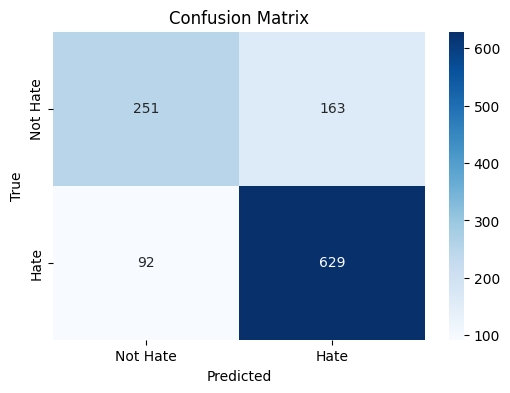

In [53]:
# Plot confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, predictions)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Not Hate", "Hate"], yticklabels=["Not Hate", "Hate"])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()